In [4]:
import utils

We load our original JSON dataset and transform it the same way we did for the Cassandra database.

In [5]:
merged_df = utils.prepare_dataset(utils.DATASET_PATH)

We then perform one additional transformation on it to make use of the `location` type specific to MongoDB, as specified [in the documentation](https://www.mongodb.com/docs/manual/geospatial-queries/).

In [6]:
def transform_to_geojson(df):
    """Transform the location for MongoDB."""

    df['location'] = df['coordinates'].apply(lambda coords: {'type': 'Point', 'coordinates': coords[:2]})
    df['depth'] = merged_df['coordinates'].apply(lambda x: x[2])

    # Delete `coordinates` column
    df.drop('coordinates', axis=1, inplace=True)
    
    return df

df = transform_to_geojson(merged_df)

We will also convert the dates into a proper format for `mongoimport`. This will allow `mongoimport` to type our dates correctly to the `ISODate` type.

In [7]:
def transform_to_mongodbdate(datetime):
    if datetime is not None:
        return {
            "$date": datetime,
        }
    else:
        return None

df['time'] = df['time'].apply(transform_to_mongodbdate)

df['updated'] = df['updated'].apply(transform_to_mongodbdate)

In [8]:
df.to_json('earthquakes_transformed.json', orient='records', lines=True)

Let’s now count the final number of records. 😊

In [9]:
len(df)

7669

In [10]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point

x = merged_df['location'].apply(lambda x: x['coordinates'][1])
y = merged_df['location'].apply(lambda x: x['coordinates'][0])

In [17]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(y, x),
    crs="EPSG:4326"  # WGS84 Latitude/Longitude
)


In [15]:
world = gpd.read_file('ne_110m_admin_0_countries.shx')


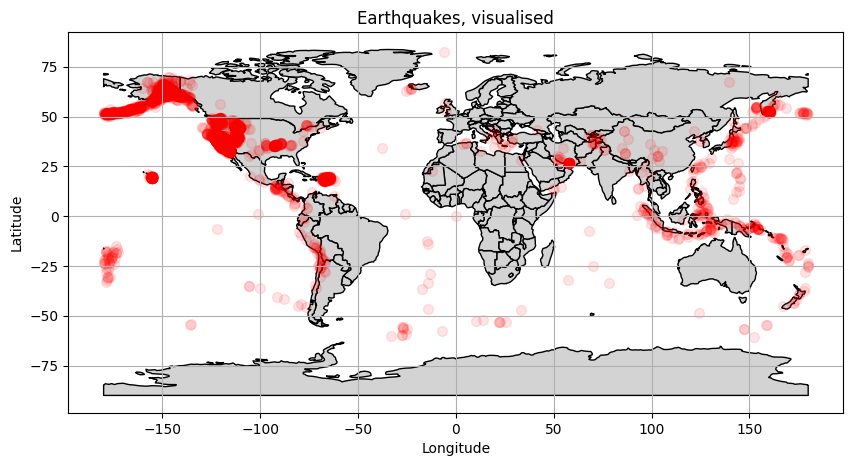

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))
world.plot(ax=ax, color='lightgray', edgecolor='black')
gdf.plot(ax=ax, color='red', alpha=0.1, markersize=5)

# Customize the plot
plt.title('Earthquakes, visualised')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)

plt.show()
